<a href="https://colab.research.google.com/github/CaouetteAI/AI-ML-Portfolio/blob/main/Beginner_Naive_Bayes_Email_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Overview:
I developed a Naive Bayes email spam classifier to address one of the most significant challenges in digital communication today. With spam comprising nearly 45% of global email traffic and cybercriminals launching over 3.4 billion phishing attacks daily, automated spam detection has become critical infrastructure for organizations worldwide. The financial stakes are enormous—IBM research shows that data breaches originating from phishing attacks cost companies an average of $4.88 million per incident.

## My Approach:
I built this classifier to demonstrate my understanding of fundamental machine learning principles, specifically focusing on Bayes' theorem and probabilistic reasoning.

## Technical Implementation:
My solution processes email text through custom preprocessing pipelines, calculates word probabilities across spam and legitimate email categories, and applies Bayes' theorem. The implementation includes comprehensive text cleaning, feature extraction, and model evaluation components.

## Skills Demonstrated:
- **Mathematical Foundation:** Deep understanding of Bayes' theorem and conditional probability
- **Algorithm Implementation:** Built classifier from scratch without relying on sklearn's built-in functions
- **Text Processing:** Developed robust preprocessing pipelines for natural language data
- **Python Programming:** Clean, well-documented code with object-oriented design principles
- **Model Evaluation:** Implemented proper train/test splits and performance metrics

In [10]:
import pandas as pd
import numpy as np
import kagglehub
import re
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [12]:
# Download latest version
path = kagglehub.dataset_download("noeyislearning/spam-emails")

In [13]:
data_path = r"/kaggle/input/spam-emails/emails.csv"

data = pd.read_csv(data_path)

data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


## **EDA Text Data**

In [14]:
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
import warnings
warnings.filterwarnings('ignore')
# Download required NLTK data
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab')
nltk.download('stopwords') # Download the stopwords corpus
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


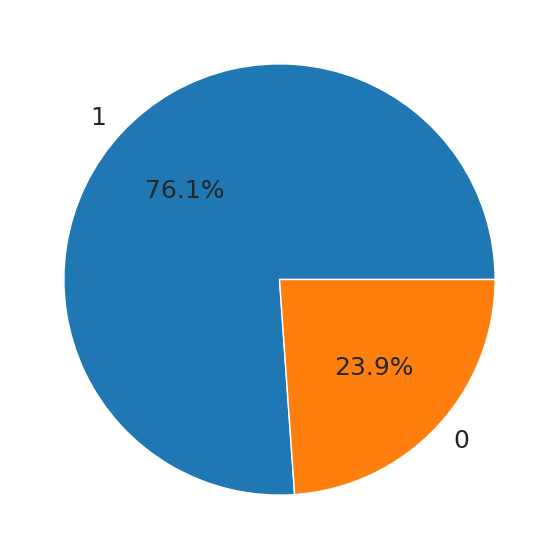

In [16]:
# Data label proportion
data['spam'] = data['spam']
plt.pie(data["spam"].value_counts(), labels = data["spam"].unique().tolist(), autopct='%1.1f%%')
plt.show()

- We can see that in the dataset the proportion of spam is 76.1% and non spam email is 23.9%. This is creating a a class imbalance in the data which means we can run into:

 - Biased Predictions - predict mostly spam since that the majority class.
 - Misleading Accuracy - By default if the model were to predict everything as spam it would have an accuracy of 76%.
 - Real World Performance: Spam rates are typically 40-50%, so keeping this ratio wont generalize well.
 - Navies Bayes Sensitivity: Since Bayes relies heavily on prior probabilites the skewed priors will skew the predictions.



In [17]:
# Length
lenght = len(data["text"][0])
print(f'The length of the first email is {lenght}')

The length of the first email is 1484


In [18]:
data ['Length'] = data['text'].str.len()
data.head()

,text,spam,Length
0,Subject: naturally irresistible your corporate...,1,1484
1,Subject: the stock trading gunslinger fanny i...,1,598
2,Subject: unbelievable new homes made easy im ...,1,448
3,Subject: 4 color printing special request add...,1,500
4,"Subject: do not have money , get software cds ...",1,235


In [19]:
# Word Count: Number of words in a text
word_count = data['text'][0].split()
print(f'Word Count: {len(word_count)}')

Word Count: 324


In [20]:
# Function to calculate the word count
def word_count(text):
  text_list = text.split()
  return len(text_list)

In [21]:
data['Word Count'] = data['text'].apply(word_count)
data.head(10)

,text,spam,Length,Word Count
0,Subject: naturally irresistible your corporate...,1,1484,324
1,Subject: the stock trading gunslinger fanny i...,1,598,89
2,Subject: unbelievable new homes made easy im ...,1,448,87
3,Subject: 4 color printing special request add...,1,500,98
4,"Subject: do not have money , get software cds ...",1,235,52
5,"Subject: great nnews hello , welcome to medzo...",1,478,84
6,Subject: here ' s a hot play in motion homela...,1,9340,1703
7,Subject: save your money buy getting this thin...,1,446,95
8,Subject: undeliverable : home based business f...,1,507,121
9,Subject: save your money buy getting this thin...,1,446,95


In [22]:
# Mean Word Length: Average length of Words
data['mean_word_length'] = data['text'].map(lambda x: np.mean([len(w) for w in x.split()]))
data.head(10)

,text,spam,Length,Word Count,mean_word_length
0,Subject: naturally irresistible your corporate...,1,1484,324,3.527778
1,Subject: the stock trading gunslinger fanny i...,1,598,89,5.685393
2,Subject: unbelievable new homes made easy im ...,1,448,87,4.057471
3,Subject: 4 color printing special request add...,1,500,98,4.040816
4,"Subject: do not have money , get software cds ...",1,235,52,3.480769
5,"Subject: great nnews hello , welcome to medzo...",1,478,84,4.511905
6,Subject: here ' s a hot play in motion homela...,1,9340,1703,4.374046
7,Subject: save your money buy getting this thin...,1,446,95,3.610526
8,Subject: undeliverable : home based business f...,1,507,121,3.123967
9,Subject: save your money buy getting this thin...,1,446,95,3.610526


In [23]:
# Calculate the sentence length per text email
# Download the missing NLTK data for sentence tokenization

data['mean_sent_length'] = data['text'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
data.head(10)

,text,spam,Length,Word Count,mean_word_length,mean_sent_length
0,Subject: naturally irresistible your corporate...,1,1484,324,3.527778,133.909091
1,Subject: the stock trading gunslinger fanny i...,1,598,89,5.685393,597.000000
2,Subject: unbelievable new homes made easy im ...,1,448,87,4.057471,110.750000
3,Subject: 4 color printing special request add...,1,500,98,4.040816,99.000000
4,"Subject: do not have money , get software cds ...",1,235,52,3.480769,24.888889
5,"Subject: great nnews hello , welcome to medzo...",1,478,84,4.511905,158.000000
6,Subject: here ' s a hot play in motion homela...,1,9340,1703,4.374046,128.388889
7,Subject: save your money buy getting this thin...,1,446,95,3.610526,47.888889
8,Subject: undeliverable : home based business f...,1,507,121,3.123967,168.333333
9,Subject: save your money buy getting this thin...,1,446,95,3.610526,47.888889


In [24]:
def visualize(col):
  print()
  plt.figure(figsize=(17, 7)) # Ensure figure size is set within the function for each plot
  plt.subplot(1,2,1)
  sns.boxplot(y=data[col], hue=data['spam'])
  plt.ylabel(col, labelpad=12.5)

  plt.subplot(1,2,2)
  # Pass the entire dataframe and specify x and hue columns
  sns.kdeplot(data=data, x=col, hue='spam', fill=True) # Added fill=True for better visualization
  plt.legend(data['spam'].unique())
  plt.xlabel(col) # Changed xlabel to the column name for clarity
  plt.ylabel('Density') # Changed ylabel to Density which is appropriate for a KDE plot
  plt.show()


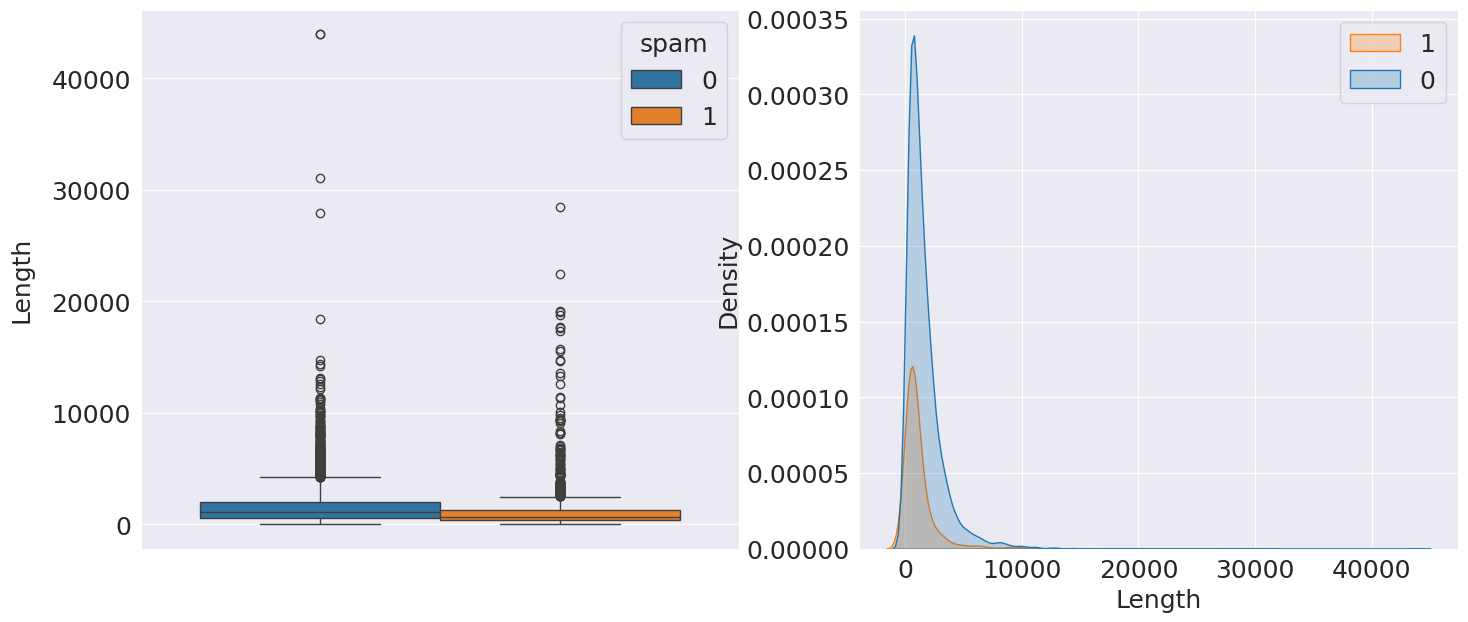

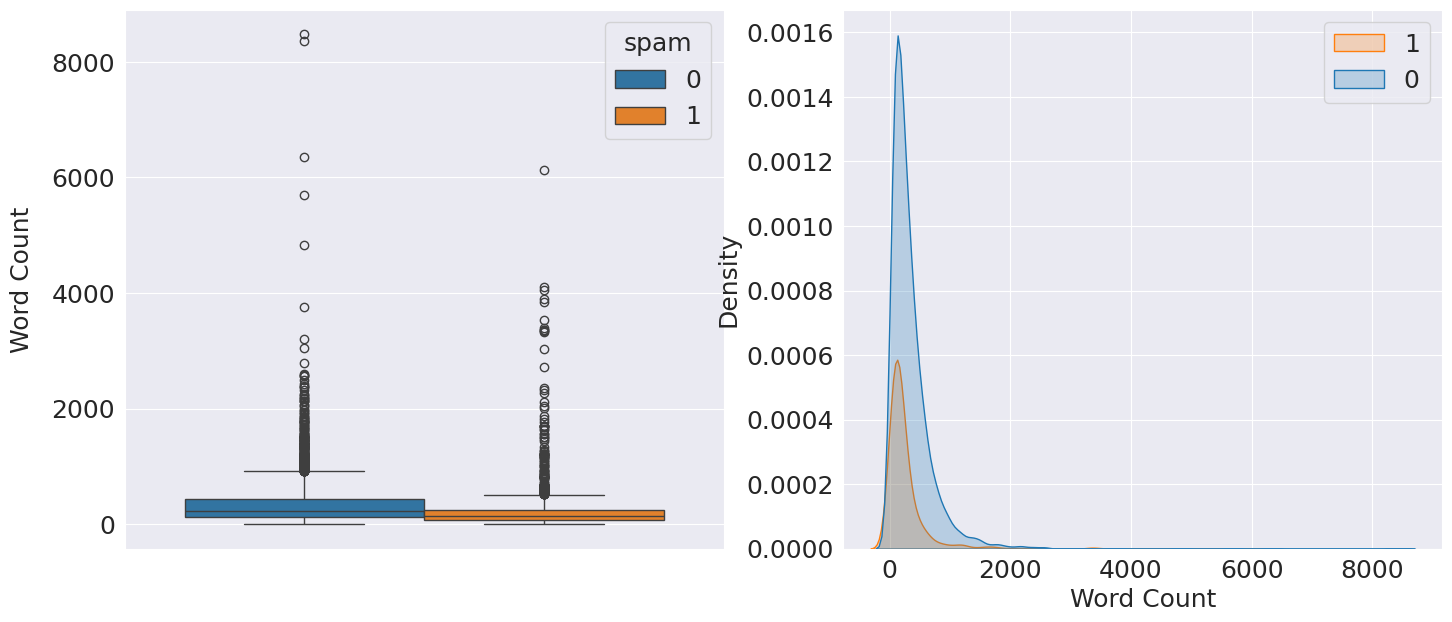

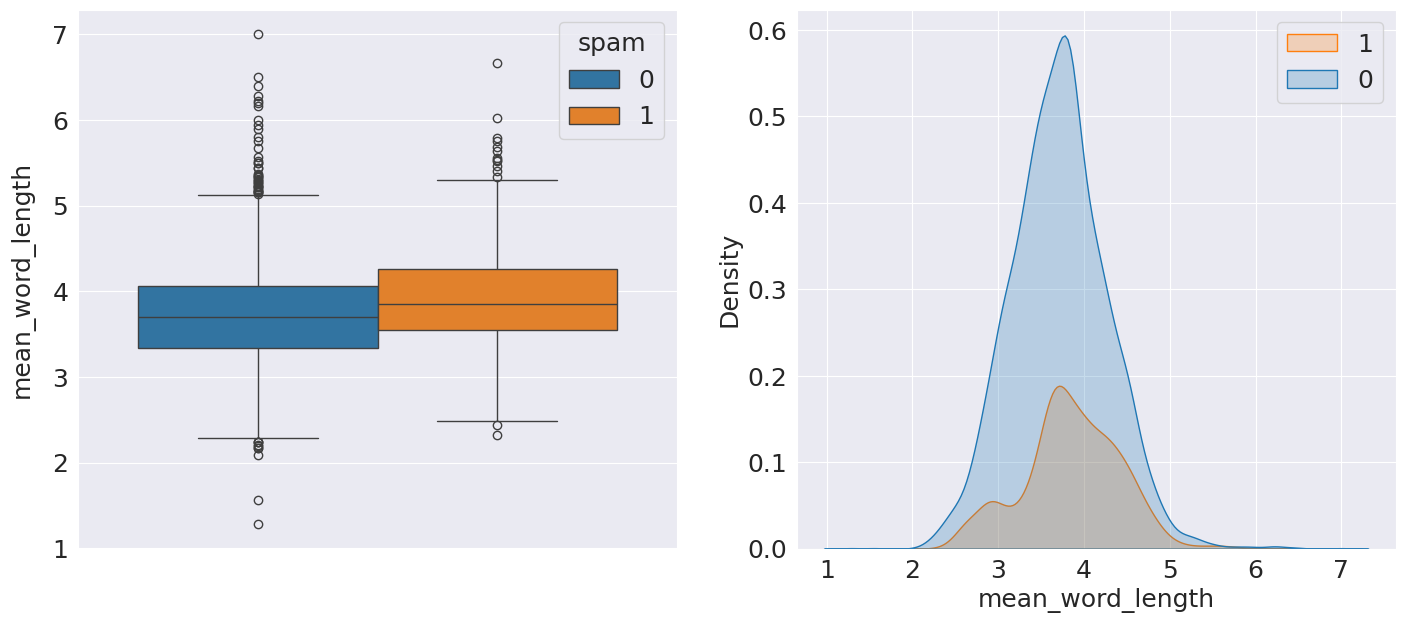

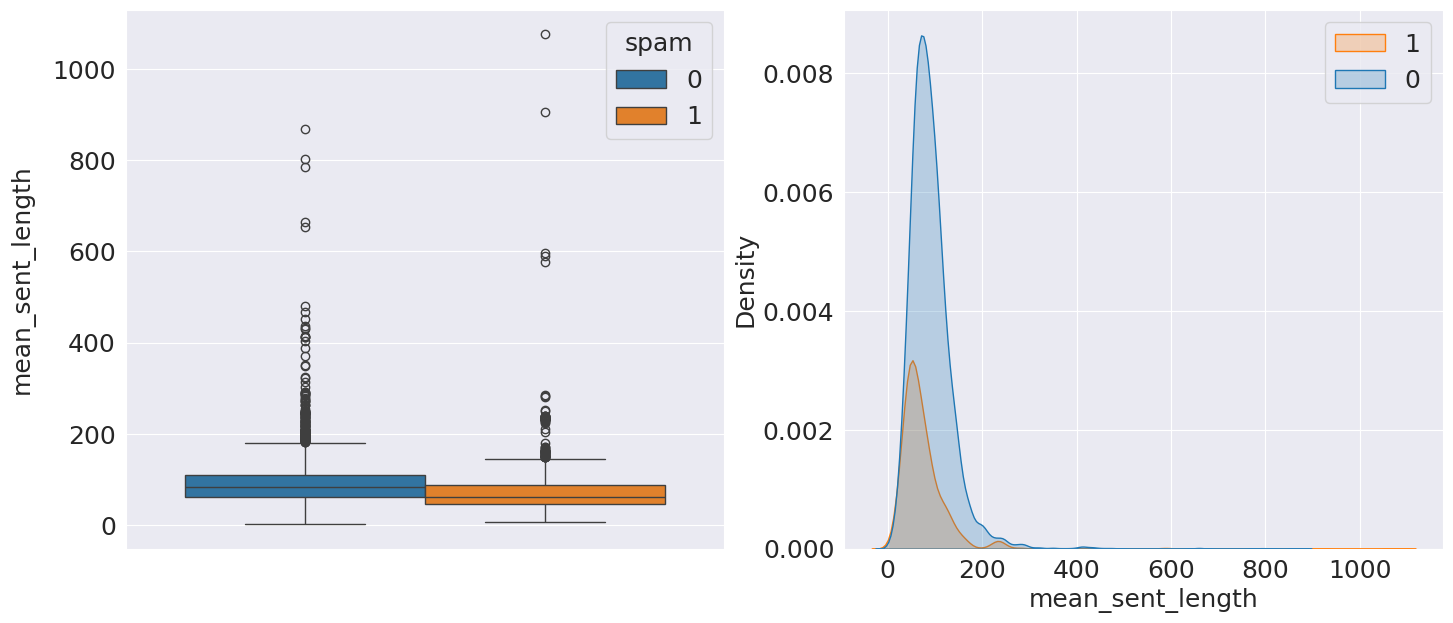

In [25]:
features = data.columns.tolist()[2:]
for feature in features:
  visualize(feature)

### **Observations**

#### **Length Key Findings**
- Most emails regardless of classification are quite short.

- Non-Spam emails show more extreme variation in length

#### **Word Count Key Findings**
- Both cateogires are typically short under 1000.

- Non spam emails show more extreme variation, with some having outliers 8000 plus.

##### **Mean Word Length Analysis**
- Non-spam emails tend to use shorter words on average (peak around 3.5 characters).

- Spam emails tend to use longer words on average (peak around 4-4.5 characters).



### **Term Frequency Analysis**

In [26]:
df = data.drop(features, axis=1)
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [28]:
from nltk.stem import WordNetLemmatizer
import re # Make sure re is imported

def clean_text(text):
  text = text.lower()
  # Replace characters that are not letters or numbers with a space
  text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text) # Added \s to keep spaces, removed hyphen
  # Remove extra spaces created by the substitution
  text = re.sub(r'\s+', ' ', text).strip()
  text = " ".join([word for word in text.split() if word not in stopwords.words('english')])
  # If you were intending to use lemmatization, uncomment the line below
  # text = " ".join([WordNetLemmatizer().lemmatize(word) for word in text.split()])
  return text

df['text'] = df['text'].apply(clean_text)
df.head()

,text,spam
0,subject naturally irresistible corporate ident...,1
1,subject stock trading gunslinger fanny merrill...,1
2,subject unbelievable new homes made easy im wa...,1
3,subject 4 color printing special request addit...,1
4,subject money get software cds software compat...,1


In [29]:
df['text']

,text
0,subject naturally irresistible corporate ident...
1,subject stock trading gunslinger fanny merrill...
2,subject unbelievable new homes made easy im wa...
3,subject 4 color printing special request addit...
4,subject money get software cds software compat...
...,...
5723,subject research development charges gpg forwa...
5724,subject receipts visit jim thanks invitation v...
5725,subject enron case study update wow day super ...
5726,subject interest david please call shirley cre...


In [30]:
df['text'][0]

'subject naturally irresistible corporate identity lt really hard recollect company market full suqgestions information isoverwhelminq good catchy logo stylish statlonery outstanding website make task much easier promise havinq ordered iogo company automaticaily become world ieader isguite ciear without good products effective business organization practicable aim hotat nowadays market promise marketing efforts become much effective list clear benefits creativeness hand made original logos specially done reflect distinctive company image convenience logo stationery provided formats easy use content management system letsyou change website content even structure promptness see logo drafts within three business days affordability marketing break make gaps budget 100 satisfaction guaranteed provide unlimited amount changes extra fees surethat love result collaboration look portfolio interested'

In [31]:
def corpus (text):
  text_list = text.split()
  return text_list

In [32]:
df['text_list'] = df["text"].apply(corpus)
df.head(10)

,text,spam,text_list
0,subject naturally irresistible corporate ident...,1,"[subject, naturally, irresistible, corporate, ..."
1,subject stock trading gunslinger fanny merrill...,1,"[subject, stock, trading, gunslinger, fanny, m..."
2,subject unbelievable new homes made easy im wa...,1,"[subject, unbelievable, new, homes, made, easy..."
3,subject 4 color printing special request addit...,1,"[subject, 4, color, printing, special, request..."
4,subject money get software cds software compat...,1,"[subject, money, get, software, cds, software,..."
5,subject great nnews hello welcome medzonline s...,1,"[subject, great, nnews, hello, welcome, medzon..."
6,subject hot play motion homeland security inve...,1,"[subject, hot, play, motion, homeland, securit..."
7,subject save money buy getting thing tried cia...,1,"[subject, save, money, buy, getting, thing, tr..."
8,subject undeliverable home based business grow...,1,"[subject, undeliverable, home, based, business..."
9,subject save money buy getting thing tried cia...,1,"[subject, save, money, buy, getting, thing, tr..."


In [33]:
# Separate the dataframe by spam type
spam_df = df[df['spam'] == 1]
non_spam_df = df[df['spam'] == 0]

# Create a corpus for spam emails by concatenating all text_list entries
spam_corpus = [word for text_list in spam_df['text_list'] for word in text_list]

# Create a corpus for non-spam emails by concatenating all text_list entries
non_spam_corpus = [word for text_list in non_spam_df['text_list'] for word in text_list]

# You can now analyze these separate corpora
print(f"Number of words in spam corpus: {len(spam_corpus)}")
print(f"Number of words in non_spam corpus: {len(non_spam_corpus)}")

# Example: Find the most common words in the spam corpus
most_common_spam = Counter(spam_corpus).most_common(10)
print("\nMost common words in spam corpus:")
print(most_common_spam)

# Example: Find the most common words in the non-spam corpus
most_common_non_spam = Counter(non_spam_corpus).most_common(10)
print("\nMost common words in non_spam corpus:")
print(most_common_non_spam)

Number of words in spam corpus: 174711
Number of words in non_spam corpus: 707431

Most common words in spam corpus:
[('subject', 1574), ('com', 999), ('1', 952), ('business', 844), ('company', 805), ('email', 804), ('information', 740), ('e', 701), ('5', 687), ('money', 662)]

Most common words in non_spam corpus:
[('enron', 13382), ('ect', 11417), ('subject', 8605), ('vince', 8531), ('hou', 5569), ('2000', 4935), ('kaminski', 4770), ('com', 4444), ('please', 4386), ('would', 4151)]


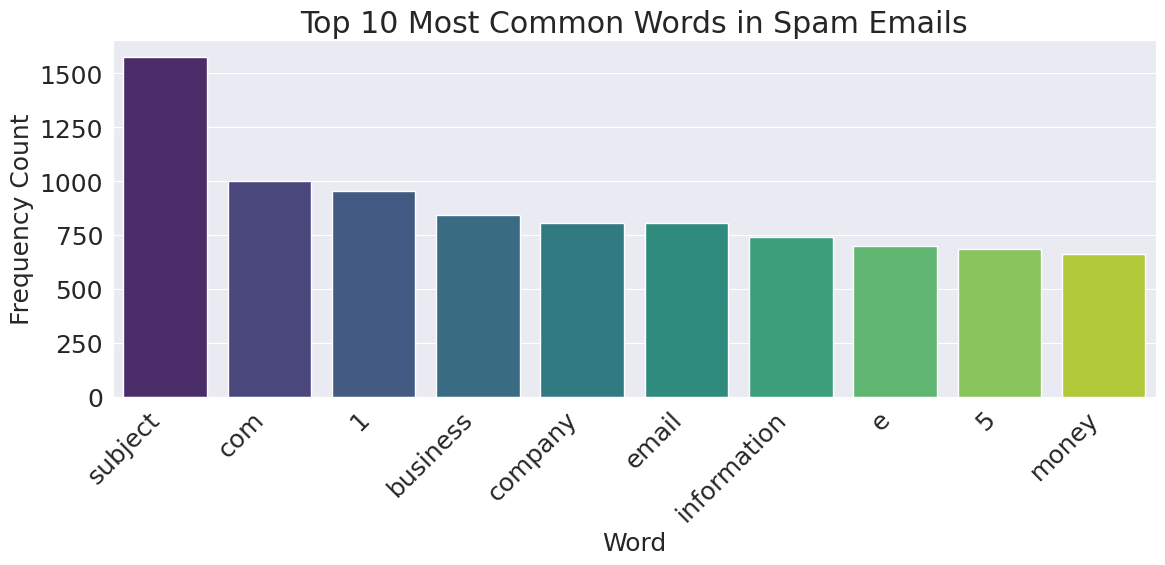

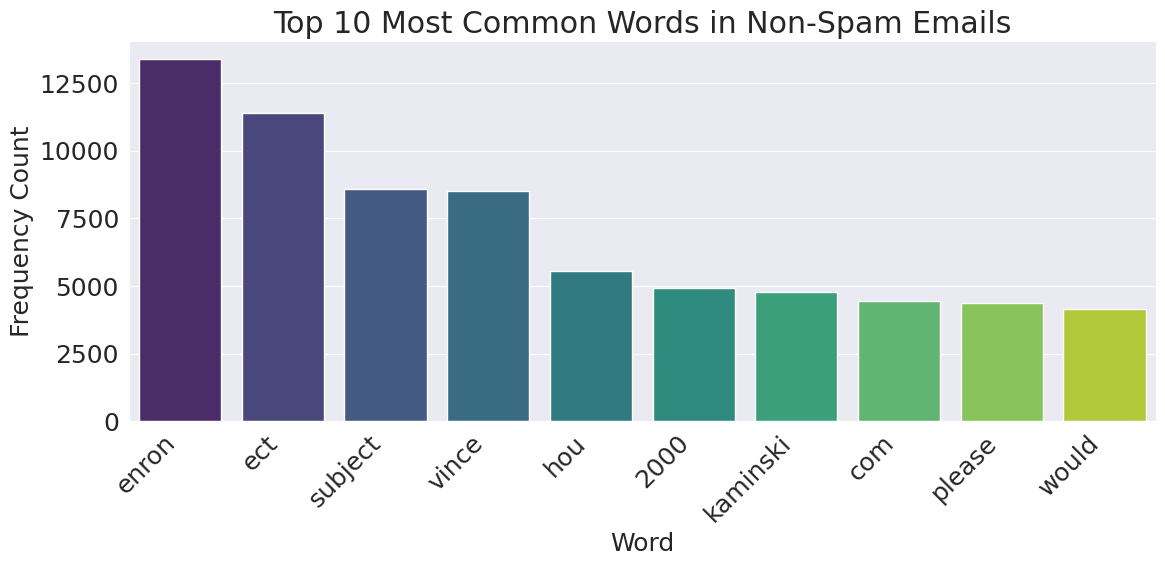

In [34]:
# Calculate frequency distribution for each corpus
spam_word_counts = Counter(spam_corpus)
non_spam_word_counts = Counter(non_spam_corpus)

# Get the top 10 most common words and their counts
most_common_spam_10 = spam_word_counts.most_common(10)
most_common_non_spam_10 = non_spam_word_counts.most_common(10)

# Create DataFrames for plotting
spam_common_df = pd.DataFrame(most_common_spam_10, columns=['word', 'count'])
non_spam_common_df = pd.DataFrame(most_common_non_spam_10, columns=['word', 'count'])

# Create the bar plot for Spam emails
plt.figure(figsize=(12, 6))
sns.barplot(data=spam_common_df, x='word', y='count', palette='viridis')
plt.title('Top 10 Most Common Words in Spam Emails')
plt.xlabel('Word')
plt.ylabel('Frequency Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create the bar plot for Non-Spam emails
plt.figure(figsize=(12, 6))
sns.barplot(data=non_spam_common_df, x='word', y='count', palette='viridis')
plt.title('Top 10 Most Common Words in Non-Spam Emails')
plt.xlabel('Word')
plt.ylabel('Frequency Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

--- Top 10 Bigrams ---

Spam Bigrams:
http www: 306
jul 2005: 159
19 jul: 154
forward looking: 112
mailing list: 112
search engines: 111
email address: 110
submit website: 103
2005 10: 102
looking statements: 101

Non-Spam Bigrams:
hou ect: 5227
ect ect: 4881
vince kaminski: 4103
enron com: 2244
cc subject: 2060
kaminski hou: 1778
ect cc: 1583
enron enron: 1554
let know: 1514
shirley crenshaw: 1045

--- Top 10 Trigrams ---

Spam Trigrams:
19 jul 2005: 154
jul 2005 10: 101
forward looking statements: 100
tue 19 jul: 97
2005 10 57: 74
10 57 46: 67
57 46 0000: 67
macromedia studio mx: 56
studio mx 2004: 55
projecthoneypot projecthoneypot org: 55

Non-Spam Trigrams:
hou ect ect: 4118
vince kaminski hou: 1778
kaminski hou ect: 1778
ect ect cc: 1525
vince kaminski enron: 895
ect cc subject: 857
corp enron enron: 819
kaminski enron com: 776
ect ect subject: 754
lon ect ect: 699


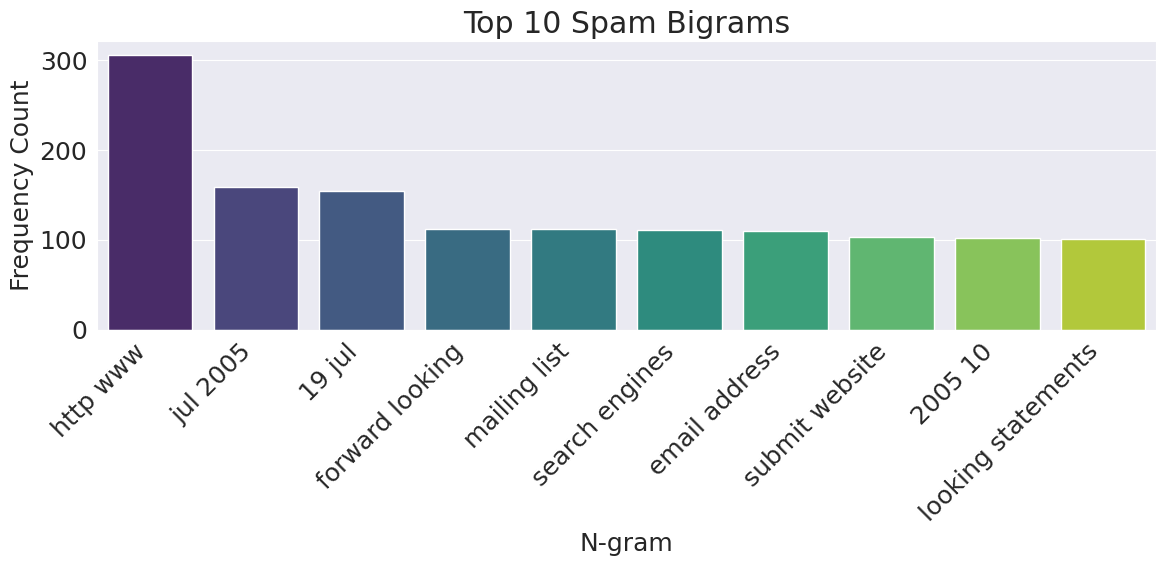

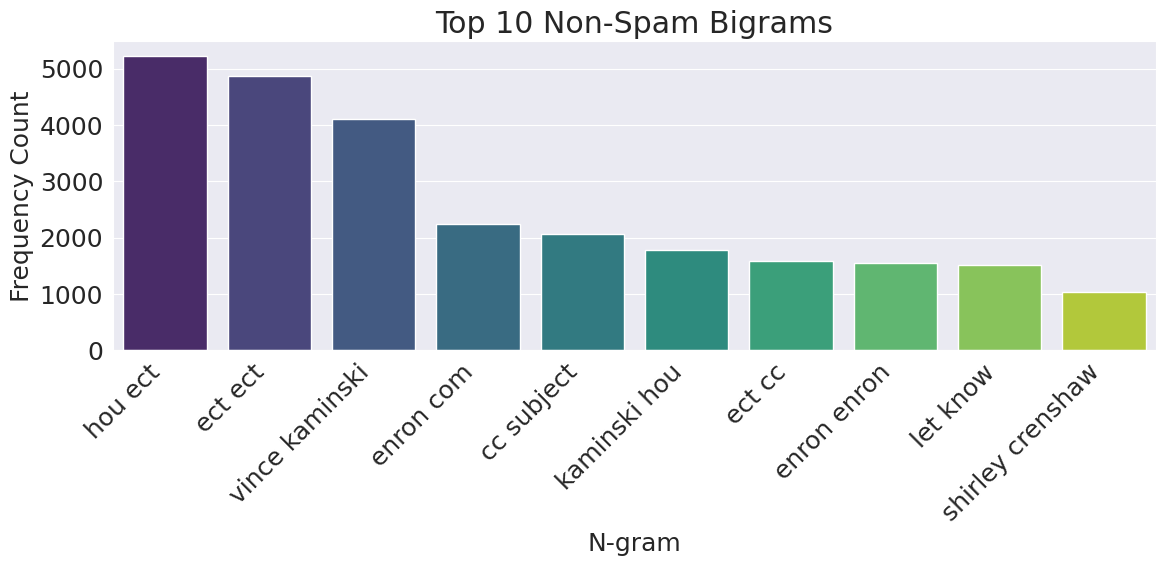

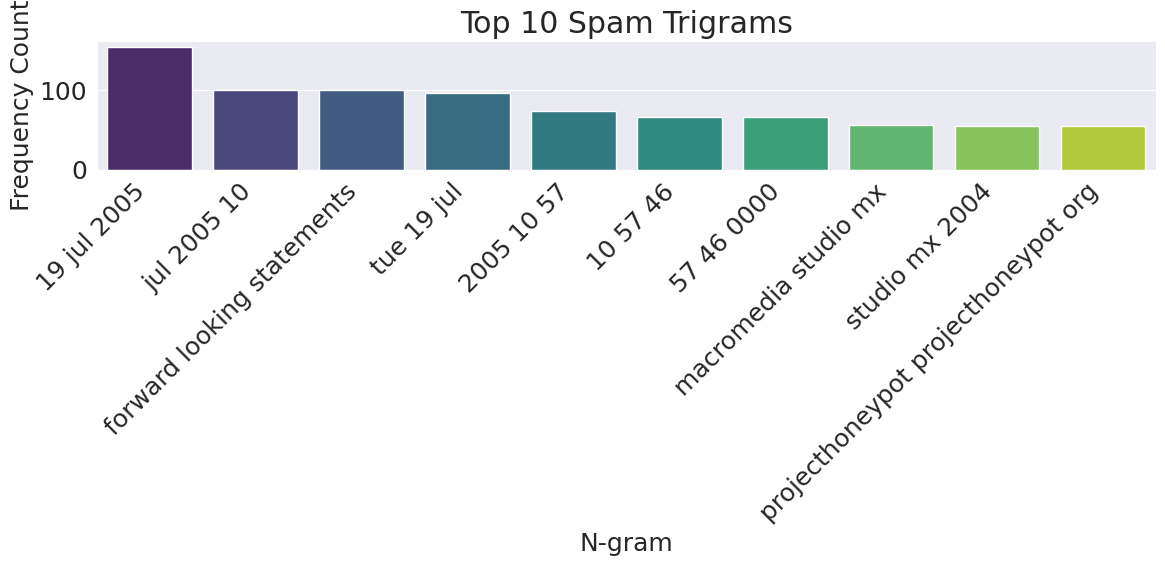

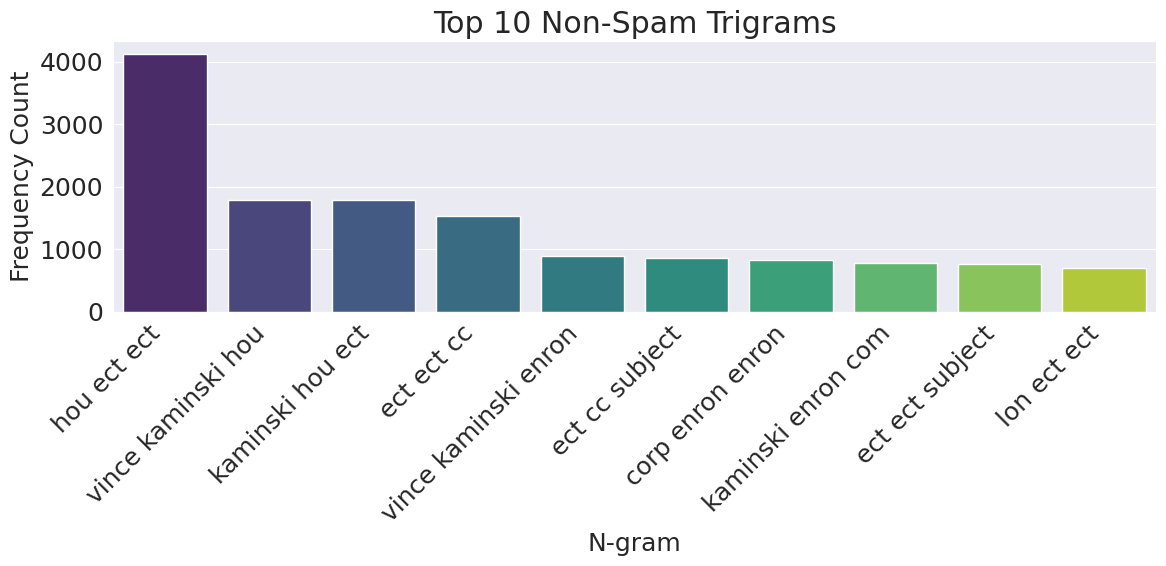

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to get top n-grams for a given text series and n-gram range
def get_top_n_grams(corpus_series, n=None, ngram_range=(1,1), top_n=10):

    # Deprecation warning for 'n'
    if n is not None:
        import warnings
        warnings.warn("The 'n' parameter is deprecated and will be removed in a future version. Use 'top_n' instead.", DeprecationWarning)
        top_n = n

    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range).fit(corpus_series)
    bag_of_words = vec.transform(corpus_series)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# Get the text series for spam and non-spam emails
spam_text_series = df[df['spam'] == 1]['text']
non_spam_text_series = df[df['spam'] == 0]['text']

# --- Bigram Analysis ---

print("--- Top 10 Bigrams ---")

# Get top 10 bigrams for spam
top_spam_bigrams = get_top_n_grams(spam_text_series, ngram_range=(2,2), top_n=10)
print("\nSpam Bigrams:")
for bigram, count in top_spam_bigrams:
    print(f"{bigram}: {count}")

# Get top 10 bigrams for non-spam
top_non_spam_bigrams = get_top_n_grams(non_spam_text_series, ngram_range=(2,2), top_n=10)
print("\nNon-Spam Bigrams:")
for bigram, count in top_non_spam_bigrams:
    print(f"{bigram}: {count}")

# --- Trigram Analysis ---

print("\n--- Top 10 Trigrams ---")

# Get top 10 trigrams for spam
top_spam_trigrams = get_top_n_grams(spam_text_series, ngram_range=(3,3), top_n=10)
print("\nSpam Trigrams:")
for trigram, count in top_spam_trigrams:
    print(f"{trigram}: {count}")

# Get top 10 trigrams for non-spam
top_non_spam_trigrams = get_top_n_grams(non_spam_text_series, ngram_range=(3,3), top_n=10)
print("\nNon-Spam Trigrams:")
for trigram, count in top_non_spam_trigrams:
    print(f"{trigram}: {count}")

# You can further visualize these using bar plots as done for single words
def plot_n_grams(n_gram_list, title):
    """Plots a bar chart of n-gram frequencies."""
    df_n_grams = pd.DataFrame(n_gram_list, columns=['ngram', 'count'])
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_n_grams, x='ngram', y='count', palette='viridis')
    plt.title(title)
    plt.xlabel('N-gram')
    plt.ylabel('Frequency Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot Spam Bigrams
plot_n_grams(top_spam_bigrams, 'Top 10 Spam Bigrams')

# Plot Non-Spam Bigrams
plot_n_grams(top_non_spam_bigrams, 'Top 10 Non-Spam Bigrams')

# Plot Spam Trigrams
plot_n_grams(top_spam_trigrams, 'Top 10 Spam Trigrams')

# Plot Non-Spam Trigrams
plot_n_grams(top_non_spam_trigrams, 'Top 10 Non-Spam Trigrams')

## **Model Consturction**

In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# The data balancing function from your notebook
def balance_data_optimized(X, y, target_ratio=1.0):
    """
    Balances the dataset by undersampling the majority class.
    """
    class_counts = np.bincount(y)
    min_class_size = np.min(class_counts)
    min_class_label = np.argmin(class_counts)
    maj_class_label = np.argmax(class_counts)

    # Indices of minority and majority class samples
    minority_indices = np.where(y == min_class_label)[0]
    majority_indices = np.where(y == maj_class_label)[0]

    # Undersample the majority class to match the minority class size
    target_majority_count = min_class_size
    majority_downsampled_indices = np.random.choice(majority_indices,
                                                    size=target_majority_count,
                                                    replace=False)

    # Combine indices
    balanced_indices = np.concatenate([minority_indices, majority_downsampled_indices])
    np.random.shuffle(balanced_indices)

    return X[balanced_indices], y[balanced_indices]

# 1. Define X and y from the original dataframe
X = np.array(df['text'].tolist())
y = np.array(df['spam'].tolist())

# 2. Split the ORIGINAL, imbalanced data first.
# Use stratify to maintain the original spam/non spam ratio in both sets.
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, y,
                                                              test_size=0.25,
                                                              random_state=42,
                                                              stratify=y)

# 3. Apply balancing ONLY to the training set
X_train_balanced, y_train_balanced = balance_data_optimized(X_train_orig, y_train_orig)

print("--- Data Shapes After Correct Handling ---")
print(f"Original training data shape: {X_train_orig.shape}")
print(f"Balanced training data shape: {X_train_balanced.shape}")
print(f"Test data shape: {X_test.shape}")
print("\nBalanced training set distribution:")
print(f"Spam: {np.sum(y_train_balanced == 1)}, Non Spam: {np.sum(y_train_balanced == 0)}")


# --- Model Training and Evaluation ---

# 4. Vectorize the text data
# Fit the vectorizer ONLY on the training data and transform both train and test data
vectorizer = CountVectorizer(binary=True, max_df=0.95)
X_train_counts = vectorizer.fit_transform(X_train_balanced)
X_test_counts = vectorizer.transform(X_test)

# 5. Train the model on the balanced training data
model = MultinomialNB()
model.fit(X_train_counts, y_train_balanced)

# 6. Evaluate the model on the original, unseen test set
y_pred = model.predict(X_test_counts)
accuracy = accuracy_score(y_test, y_pred)

print("\n--- Model Evaluation on Unseen Test Data ---")
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

--- Data Shapes After Correct Handling ---
Original training data shape: (4296,)
Balanced training data shape: (2052,)
Test data shape: (1432,)

Balanced training set distribution:
Spam: 1026, Non Spam: 1026

--- Model Evaluation on Unseen Test Data ---
Accuracy: 0.9923

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1090
           1       0.98      0.99      0.98       342

    accuracy                           0.99      1432
   macro avg       0.99      0.99      0.99      1432
weighted avg       0.99      0.99      0.99      1432

Confusion Matrix:
[[1083    7]
 [   4  338]]


In [37]:
from sklearn.metrics import accuracy_score

# Use the trained model to make predictions on the vectorized test data
y_test_pred = model.predict(X_test_counts)

# Compare the model's predictions (y_test_pred) with the actual labels (y_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the final testing accuracy
print(f"Testing Accuracy: {test_accuracy:.4f}")

Testing Accuracy: 0.9923
